<a href="https://colab.research.google.com/github/nisaruj/Chemception-plus/blob/master/Chemception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

### Install packages

In [1]:
!pip install -q pubchempy imblearn

In [2]:
%%capture
!wget -c https://repo.continuum.io/miniconda/Miniconda3-py37_4.8.3-Linux-x86_64.sh
!chmod +x Miniconda3-py37_4.8.3-Linux-x86_64.sh
!time bash ./Miniconda3-py37_4.8.3-Linux-x86_64.sh -b -f -p /usr/local 
!time conda install -q -y -c conda-forge rdkit

import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

### Import mapping data

In [3]:
!wget -q https://github.com/nisaruj/Chemception-plus/raw/master/data/nsc_smiles.pickle

In [4]:
# !cp drive/My\ Drive/BIOINFO/nsc_smiles.pickle ./nsc_smiles.pickle

### Import dataset

In [5]:
!wget -q -O dataset.csv https://raw.githubusercontent.com/nisaruj/Chemception-plus/master/data/aids_conc_may04.csv

In [6]:
# !cp drive/My\ Drive/BIOINFO/aids_conc_may04.txt ./dataset.csv
# Trim whitespaces from dataset file
# !sed -r "s/[ \t]//g" dataset.csv > out.csv
# !mv out.csv dataset.csv

## Preprocess

CNN requires 2D matrix so we need to convert NSC id -> -> SMILES -> 2D grid image

### Visualize dataset

* CA - Confirmed active
* CM - Confirmed moderately active
* CI - Confirmed inactive

In [7]:
import pandas as pd

data = pd.read_csv("dataset.csv")
data.head(5)

,NSC,Conclusion
0,48,CI
1,78,CI
2,128,CI
3,163,CI
4,164,CI


We use NSC dataset which uses an internal id to identify a molecule so we need to create a mapping that converts NSC id to SMILES.

We can use PubChem api to retrieve smiles from NSC id

In [8]:
import pubchempy as pcp
pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC170', 'name')

[{'CID': 219201,
  'CanonicalSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC',
  'IsomericSMILES': 'CCOP(=O)(NC1=CC(=CC=C1)Cl)OCC'}]

In [9]:
# from progressbar import progressbar

# NSC2SMILES = {}
# start_from = 722245
# for compound_id in progressbar(data['NSC']):
#   if compound_id in NSC2SMILES:
#     continue
#   if compound_id < start_from:
#     continue
#   props = pcp.get_properties(['IsomericSMILES', 'CanonicalSMILES'], 'NSC' + str(compound_id), 'name')
#   if len(props) > 0:
#     NSC2SMILES[compound_id] = props[0]

In [10]:
# import pickle

# with open('nsc_smiles.pickle', 'wb') as handle:
#     pickle.dump(NSC2SMILES, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [11]:
import pickle

with open('nsc_smiles.pickle', 'rb') as fp:
  NSC2SMILES = pickle.load(fp)
  
len(NSC2SMILES)

42407

In [12]:
NSC2SMILES[7816]

{'CID': 73120,
 'CanonicalSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl',
 'IsomericSMILES': 'C1=CC=C2C(=C1)C(OS2(=O)=O)(C3=CC(=C(C(=C3)Br)O)Cl)C4=CC(=C(C(=C4)Br)O)Cl'}

We remove the data that isn't compound (ie. substance).

In [13]:
data['is_compound'] = data['NSC'].isin(NSC2SMILES)
data = data[data['is_compound'] == True]

Like the paper, the problem was reduced to binary classification by setting CI to 0 and CM/CA to 1.

In [14]:
data['active'] = data['Conclusion'].isin(['CM', 'CA'])
data.head(5)

,NSC,Conclusion,is_compound,active
2,128,CI,True,False
3,163,CI,True,False
4,164,CI,True,False
5,170,CI,True,False
6,180,CI,True,False


Counter({False: 40859, True: 1548})


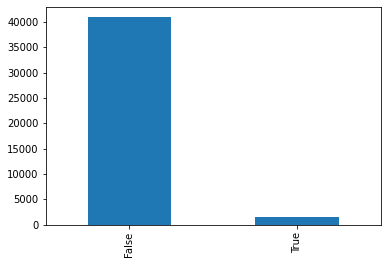

In [15]:
from collections import Counter
print(Counter(data['active']))

data['active'].value_counts().plot(kind='bar');

### Chemcepterize NSC compound

`chemcepterizeFromNsc` converts a molecule into a color-coded grid image.

In [16]:
from rdkit import Chem
from rdkit.Chem import Draw
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def molFromNsc(nsc):
  return Chem.MolFromSmiles(NSC2SMILES[nsc]['IsomericSMILES'])

def drawFromNsc(nsc):
  Draw.MolToMPL(molFromNsc(nsc), size=(100, 100))

'''
https://www.cheminformania.com/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/
Note that the code above uses 4 channel image but the paper uses only 1 channel (greyscale).
We'll use 4 channel anyway.

@param embed
@param res - Resolution of each pixel (Å)
'''
def chemcepterizeFromNsc(nsc, embed=20.0, res=0.5):
    mol = molFromNsc(nsc)
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    Chem.AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4))
    #Bonds first
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2))
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

def drawChemceptionVector(v):
  plt.imshow(v[:,:,:3])

def drawChemceptionFromNsc(nsc, embed=20.0, res=0.5):
  v = chemcepterizeFromNsc(nsc, embed=embed, res=res)
  drawChemceptionVector(v)

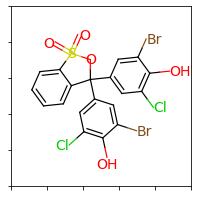

In [17]:
drawFromNsc(7816)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


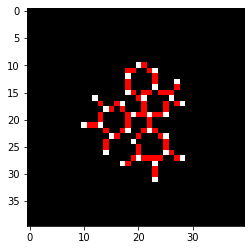

In [18]:
drawChemceptionFromNsc(7816, embed=10)

### Preprocess data

Stratify and do random over-sampling the data

In [19]:
from sklearn.model_selection import train_test_split

train_data, test_data = train_test_split(data, stratify=data['active'], test_size=1/6)
X_train, y_train = train_data['NSC'], train_data['active']
X_test, y_test = test_data['NSC'], test_data['active']

print(len(X_train), len(X_test), len(y_train), len(y_test))
print(Counter(y_train), Counter(y_test))

35339 7068 35339 7068
Counter({False: 34049, True: 1290}) Counter({False: 6810, True: 258})


In [ ]:
X_train

In [22]:
X_train.reshape(-1)

AttributeError: ignored

In [21]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler()
X_train_ros, y_test_ros = ros.fit_resample(X_train, y_test)
print(Counter(X_train_ros), Counter(y_test_ros))

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


ValueError: ignored